In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random
import torch
torch.cuda.set_device(0)
import numpy as np
import cv2
import PIL
from PIL import Image, ImageOps

C:\Users\iisaragon\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\iisaragon\anaconda3\envs\torch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
import sys
sys.path.insert(1, '../utils/')
from kfold import *
sys.path.insert(1, '../utils/')
from metrics import *

### We set a random seed for reproducibility

In [3]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
path=Path('../dataset')
path_train=path/'train'
files=[path_train/f for f in os.listdir(path_train)]

### We show some images and its mask

<Axes: >

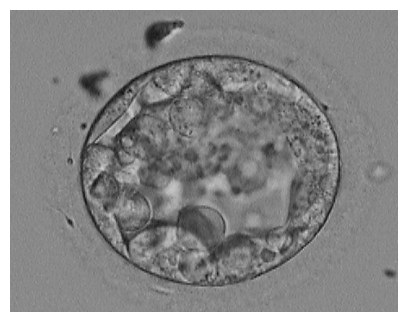

In [8]:
img = PILImage.create(files[1])
img.show(figsize=(5, 5))

In [6]:
get_y_fn = lambda x: Path(str(x).replace("train","GT_Mask"))

<Axes: >

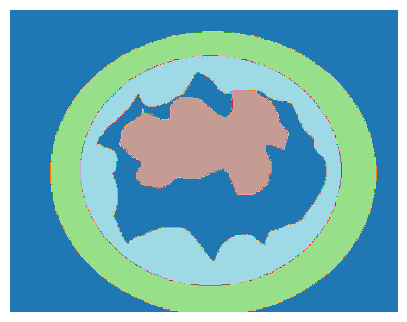

In [10]:
mask = PILMask.create(get_y_fn(files[1]))
mask.show(figsize=(5, 5), alpha=1)

### Setting some transformormations for data augmentation

In [9]:
from albumentations import (Compose,OneOf,ElasticTransform,GridDistortion, OpticalDistortion,HorizontalFlip,Rotate,Transpose,CLAHE,ShiftScaleRotate)
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [ ]:
transforms=Compose([HorizontalFlip(p=0.5),Rotate(p=0.40,limit=10)],p=1)
transformPipeline=SegmentationAlbumentationsTransform(transforms)

### Transforming our  Ground Truth masks

In [12]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        # {'TE':255, 'ICM':150,'ZP':75}
        mask[mask==0]=0
        mask[mask==75]=1
        mask[mask==255]=2
        mask[mask==150]=3     
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [15]:
codes = np.array(['Background','ZP', 'TE', 'ICM'])

### Datablock

In [16]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((480,480)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

In [17]:
bs = 2
path_images=path_train
trainDLS = trainDB.dataloaders(path_images,bs=bs)

### Setting the accuracy for each structure

In [18]:
def msa(input, target):
    target = target.squeeze(1)
    mask = target != -1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def background(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def zp(input, target):
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def te(input, target):
    target = target.squeeze(1)
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def icm(input, target):
    target = target.squeeze(1)
    mask = target != 3
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

## Training

### Define the model

**model**: hrnet

**backbone**: hrnet_w30

In [19]:
learn = get_segmentation_learner(dls=trainDLS, number_classes=4, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[background,zp,te,icm,msa],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

147942KB [00:05, 25602.62KB/s]                                                                                         


#### Find learning rate

SuggestedLRs(valley=9.120108734350652e-05)

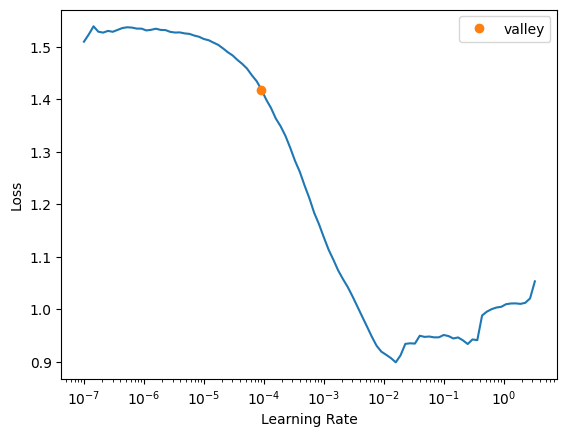

In [20]:
learn.lr_find()

In [ ]:
monitor_training="valid_loss"
comp_training=np.less
monitor_evaluating="dice"
comp_evaluating=np.greater
patience=2

fname="../models/hrnet-before-unfreeze"

callbacksFitBeforeUnfreeze = [ShowGraphCallback(), EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
                              SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)]

#### Train for 20 epochs

epoch,train_loss,valid_loss,background,zp,te,icm,msa,time
0,1.168524,1.241553,0.792839,0.622294,0.622821,0.625261,0.646859,00:25
1,0.657155,0.811420,0.911537,0.794479,0.813699,0.808867,0.820491,00:26
2,0.395711,0.515060,0.859881,0.894133,0.900099,0.892411,0.891312,00:26
3,0.290864,0.289608,0.887723,0.910568,0.913904,0.910451,0.908834,00:25
4,0.242245,0.231510,0.867071,0.914330,0.919355,0.928262,0.914757,00:25
5,0.212069,0.219686,0.848801,0.916670,0.928108,0.926853,0.915526,00:25
6,0.184452,0.199640,0.905256,0.922779,0.932342,0.926218,0.925088,00:26
7,0.174860,0.205280,0.851977,0.925384,0.937550,0.924452,0.919809,00:26
8,0.152380,0.202158,0.861408,0.927441,0.932407,0.926722,0.921450,00:24


Better model found at epoch 0 with valid_loss value: 1.2415530681610107.


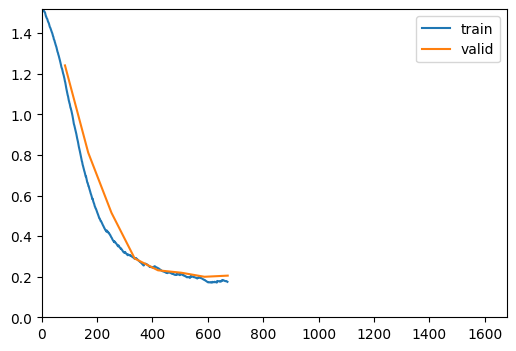

Better model found at epoch 1 with valid_loss value: 0.8114200830459595.
Better model found at epoch 2 with valid_loss value: 0.5150600075721741.
Better model found at epoch 3 with valid_loss value: 0.28960832953453064.
Better model found at epoch 4 with valid_loss value: 0.231509730219841.
Better model found at epoch 5 with valid_loss value: 0.2196863740682602.
Better model found at epoch 6 with valid_loss value: 0.19963954389095306.
No improvement since epoch 6: early stopping


In [21]:
learn.fit_one_cycle(20, slice(1e-4,1e-4),cbs=callbacksFitBeforeUnfreeze)

#### Unfreeze

In [22]:
learn.load("../models/hrnet-before-unfreeze")
learn.unfreeze()

C:\Users\iisaragon\anaconda3\envs\torch\lib\site-packages\fastai\learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


#### Set callbacks after unfreeze

In [ ]:
fname="../../../3_models/hrnet-after-unfreeze"


callbacksFitAfterUnfreeze = [ShowGraphCallback(),EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
                             SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)]

#### Train for 20 epochs

epoch,train_loss,valid_loss,background,zp,te,icm,msa,time
0,0.158942,0.193195,0.909431,0.924659,0.932750,0.928217,0.926852,00:24
1,0.157439,0.191101,0.909817,0.925182,0.932729,0.928792,0.927224,00:25
2,0.162892,0.190195,0.909063,0.925612,0.932911,0.929157,0.927412,00:26
3,0.156697,0.189402,0.908962,0.925915,0.933278,0.929340,0.927643,00:25
4,0.165103,0.189047,0.908913,0.926132,0.933203,0.929453,0.927716,00:24
5,0.152657,0.188541,0.908735,0.926396,0.933417,0.929630,0.927879,00:24
6,0.159109,0.187897,0.908349,0.926865,0.933759,0.929776,0.928095,00:27
7,0.162979,0.187575,0.908924,0.926966,0.933764,0.929770,0.928182,00:27
8,0.154670,0.187156,0.908330,0.927237,0.934117,0.929934,0.928337,00:27
9,0.165414,0.186850,0.908032,0.927434,0.934190,0.930060,0.928417,00:25


Better model found at epoch 0 with valid_loss value: 0.19319507479667664.


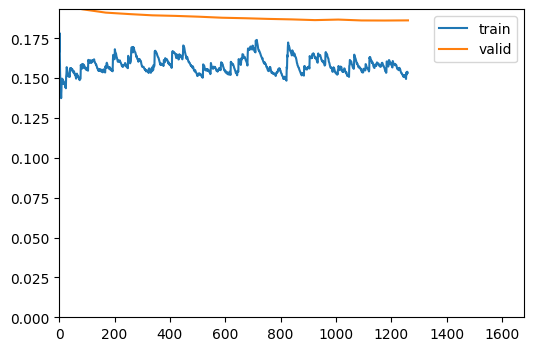

Better model found at epoch 1 with valid_loss value: 0.19110123813152313.
Better model found at epoch 2 with valid_loss value: 0.19019486010074615.
Better model found at epoch 3 with valid_loss value: 0.1894017457962036.
Better model found at epoch 4 with valid_loss value: 0.18904656171798706.
Better model found at epoch 5 with valid_loss value: 0.18854102492332458.
Better model found at epoch 6 with valid_loss value: 0.1878965198993683.
Better model found at epoch 7 with valid_loss value: 0.18757474422454834.
Better model found at epoch 8 with valid_loss value: 0.1871558278799057.
Better model found at epoch 9 with valid_loss value: 0.186849907040596.
Better model found at epoch 10 with valid_loss value: 0.186397522687912.
Better model found at epoch 12 with valid_loss value: 0.18618659675121307.
Better model found at epoch 13 with valid_loss value: 0.18613828718662262.
No improvement since epoch 13: early stopping


In [23]:
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

### Validation

In [24]:
learn.validate()

(#6) [0.18613828718662262,0.9078754186630249,0.9277256727218628,0.9344282746315002,0.9302212595939636,0.9285878539085388]

### Predictions of the training set

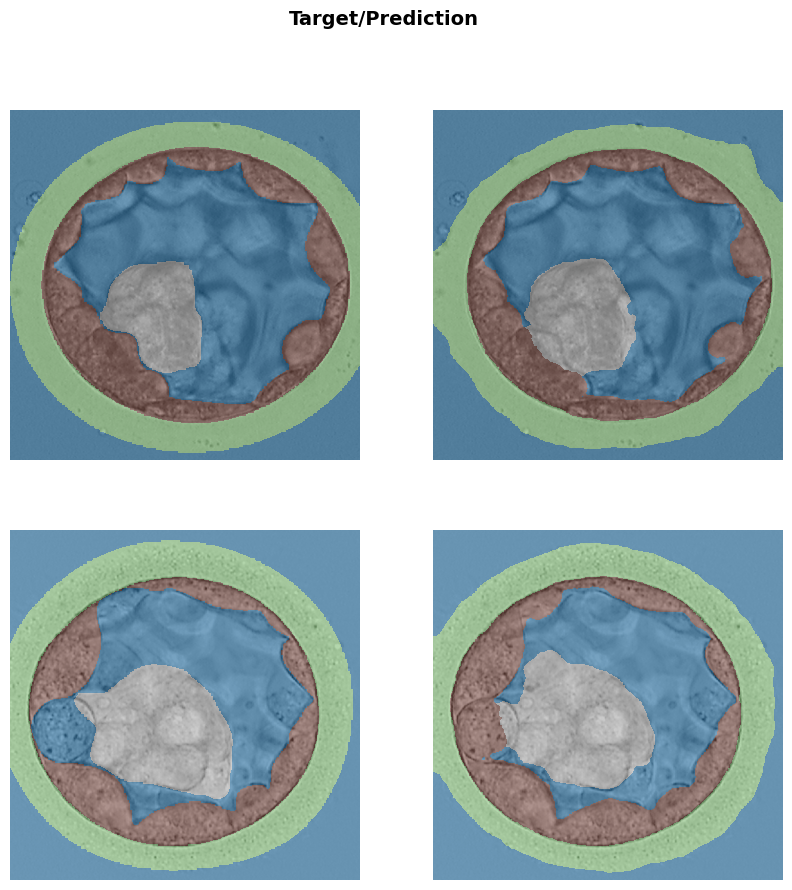

In [25]:
learn.show_results(figsize=(10,10))

### Saving the model

In [26]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("../models/models/hrnet.pth")

### Load the model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = torch.jit.load("../models/models/hrnet.pth")
model = model.cpu()

#### Define prediction function for predicting from a path

In [8]:
import torchvision.transforms as transforms
def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

In [9]:
def prediction(path):
    img = PIL.Image.open(path).convert('RGB')
    image = transforms.Resize((480,480))(img)
    tensor = transform_image(image=image)
    model.to(device)
    with torch.no_grad():
        outputs = model(tensor)

    outputs = torch.argmax(outputs,1)
    mask = np.array(outputs.cpu())
    mask[mask==1]=75
    mask[mask==2]=255
    mask[mask==3]=150
    mask=np.reshape(mask,(480,480))
    return np.array(transforms.Resize(img.shape)(Image.fromarray(mask.astype('uint8'))))

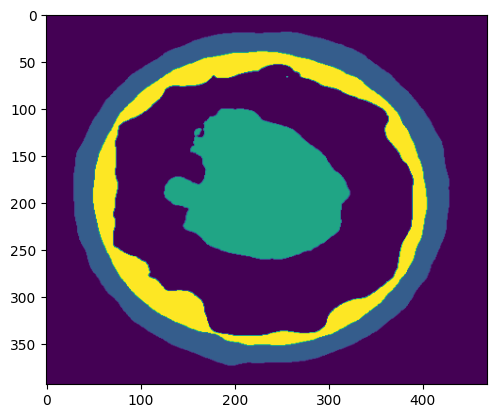

In [13]:
mask=prediction('../dataset/test/Blast_PCRM_R12-0316a.BMP')
img=cv2.imread('../dataset/test/Blast_PCRM_R12-0316a.BMP', cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)

#### Saving the predictions

In [ ]:
os.mkdir('hrnet')

In [10]:
path_save=Path('hrnet')
os.mkdir(path_save)
for f in files:
    pred=prediccion(str(f))
    cv2.imwrite(str(path_save/f.name), pred)

### Evaluation

#### Define the metrics

In [14]:
def accuracy(target, prediction):
    true_detec = np.logical_not(np.logical_xor(target, prediction))
    return np.sum(true_detec)/np.sum(np.ones_like(target))

def precision(target, prediction):
    intersection = np.logical_and(target, prediction)
    return np.sum(intersection)/np.sum(prediction)

def recall(target, prediction):
    intersection = np.logical_and(target, prediction)
    return np.sum(intersection)/np.sum(target)

def jaccard(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    return np.sum(intersection) / np.sum(union)

def dice(target, prediction):
    intersection = np.logical_and(target, prediction)
    return 2*np.sum(intersection) / (np.sum(target) + np.sum(prediction))

def metrics(target, prediction):
    return {'accuracy': accuracy(target, prediction),
            'precision': precision(target, prediction),
            'recall': recall(target, prediction),
            'specificity': recall(1-target,1- prediction),
            'jaccard':jaccard(target, prediction),
            'dice': dice(target, prediction)}

def summary_metrics(y_test,predictions):
    a,p,r,s,j,d=0.,0.,0.,0.,0.,0.
    n=len(predictions)
    for i in range(n):
        preds= predictions[i]==255
        gt= y_test[i]==255
        metricas=metrics(gt,preds)
        a+=metricas['accuracy']
        p+=metricas['precision']
        r+=metricas['recall']
        s+=metricas['specificity']
        j+=metricas['jaccard']
        d+=metricas['dice']
    return {'accuracy': a/n,
            'precision': p/n,
            'recall': r/n,
            'specificity': s/n,
            'jaccard':j/n,
            'dice': d/n}

In [15]:
def get_mask(path,string,path_gt):
    file='GT_{}/'.format(string) +path.stem+' {}_Mask.bmp'.format(string)
    path_gt_file=str(path_gt/file)
    return cv2.imread(path_gt_file,cv2.IMREAD_GRAYSCALE)

In [16]:
path_test=path/'test'
files=[path_test/f for f in os.listdir(path_test)]
gtruth_zp=[get_mask(f,'ZP',path) for f in files]
gtruth_te=[get_mask(f,'TE',path) for f in files]
gtruth_icm=[get_mask(f,'ICM',path) for f in files]

In [18]:
preds=[prediction(f) for f in files]

C:\Users\iisaragon\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\module.py:1501: UserWarning: operator () profile_node %750 : bool = prim::profile_ivalue(%training.926)
 does not have profile information (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\third_party\nvfuser\csrc\graph_fuser.cpp:108.)
  return forward_call(*args, **kwargs)


In [19]:
preds_zp=[255*(p==75).astype('uint8') for p in preds]  
preds_te=[255*(p==255).astype('uint8') for p in preds]
preds_icm=[255*(p==150).astype('uint8') for p in preds]  

In [45]:
summary_metrics(gtruth_zp,preds_zp)

{'accuracy': 0.9651843334487191,
 'precision': 0.9057659756521715,
 'recall': 0.8314137676385994,
 'specificity': 0.9860185881075448,
 'jaccard': 0.7691083311287479,
 'dice': 0.8616685671212155}

In [46]:
summary_metrics(gtruth_te,preds_te)

{'accuracy': 0.9624546183148832,
 'precision': 0.8402059772137176,
 'recall': 0.8134268442918693,
 'specificity': 0.9809797896416146,
 'jaccard': 0.7053080659178964,
 'dice': 0.8222672179176866}

In [49]:
summary_metrics(gtruth_icm,preds_icm)

{'accuracy': 0.9796397385091486,
 'precision': 0.8643254259076774,
 'recall': 0.8529776190434408,
 'specificity': 0.9904016147728348,
 'jaccard': 0.765196762278296,
 'dice': 0.8495913973615591}

### INFERENCE

In [20]:
path_image='../img.png'
mask=prediction(path_image)

In [21]:
img=cv2.imread(path_image)

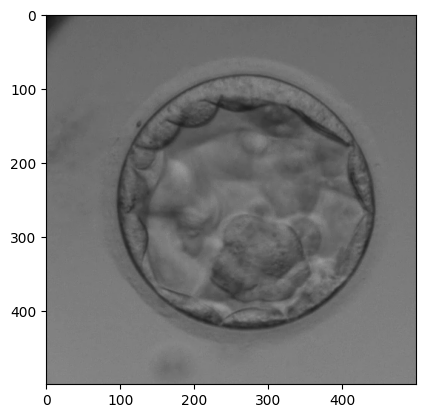

In [22]:
plt.imshow(img)

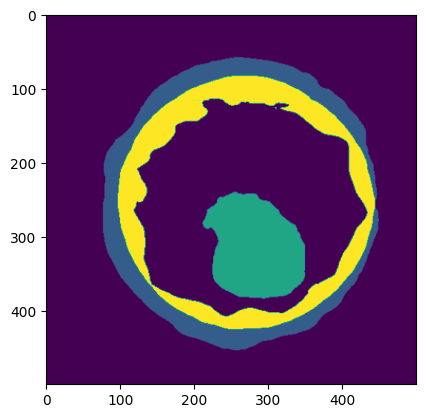

In [23]:
plt.imshow(mask)